# 50.039 Theory and Practice of Deep Learning Project 2024

Group 10
- Issac Jose Ignatius (1004999)
- Mahima Sharma (1006106)
- Dian Maisara (1006377)


## 1. Setup

### Import all relevant libraries

In [16]:
# Numpy
import numpy as np
# Pandas
import pandas as pd
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision
print(torchvision.__version__)
import torchvision.transforms as T
from torchvision.transforms import v2
import torchvision.transforms.functional as fn
from torchvision.io import read_image, ImageReadMode
from torchmetrics.classification import MulticlassF1Score
import math

# Copy
from copy import deepcopy

# Helpers
import sys
sys.path.insert(0, '../utils')

from helpers import *
from models import ConvSingle
from preprocessors import *

0.17.2+cu121


### Set device to CUDA

In [17]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Setup path to dataset


In [18]:
DATA_PATH = os.path.join(os.path.abspath(''), "../../original")
print(DATA_PATH)

c:\Users\dianm\Downloads\Dataset\2024_TPDL\notebooks\../../original


### Set seed to all processes

In [19]:
seed_everything(42)

### Load in Train and Validation Sets

In [20]:
labels = ['Pleural Effusion', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Edema', 'Pleural Other', 'Fracture', 'Support Devices']

train_df = pd.read_csv("../data/processed/train_one_hot_encoded.csv", index_col=False)
train_df["Path"] = train_df["Path"].apply(fix_error_paths)
valid_df = pd.read_csv("../data/processed/valid_one_hot_encoded.csv", index_col=False)

for label in labels:
    train_df[label] = train_df[label].apply(str_to_array)
    valid_df[label] = valid_df[label].apply(str_to_array)

display(train_df)
display(valid_df)

,Path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
1,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
2,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
3,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
4,CheXphoto-v1.0/train/synthetic/digital/patient...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32516,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
32517,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
32518,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
32519,CheXphoto-v1.0/train/natural/nokia/patient6446...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"


,Path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
1,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
2,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
3,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
4,CheXphoto-v1.0/valid/synthetic/digital/patient...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
698,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
699,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
700,CheXphoto-v1.0/valid/natural/oneplus/patient64...,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"


### Prepare Pleural Effusion and Cardio Train & Validation Sets


In [21]:
# Creates copy of train_df for pEff and cardio
train_p = train_df.copy()
valid_p = valid_df.copy()
train_c = train_df.copy()
valid_c = valid_df.copy()

In [22]:
# Drop all other labels
pEff_train = preprocess_pEffClassification(train_p)
pEff_valid = preprocess_pEffClassification(valid_p)

pEff_train["Pleural Effusion"] = pEff_train["Pleural Effusion"].apply(ohe_to_class)
pEff_valid["Pleural Effusion"] = pEff_valid["Pleural Effusion"].apply(ohe_to_class)

pEff_train = pEff_train[pEff_train["Pleural Effusion"] != -100]

display(pEff_train)
display(pEff_valid)

,Path,Pleural Effusion
0,CheXphoto-v1.0/train/synthetic/digital/patient...,1
1,CheXphoto-v1.0/train/synthetic/digital/patient...,1
4,CheXphoto-v1.0/train/synthetic/digital/patient...,2
5,CheXphoto-v1.0/train/synthetic/digital/patient...,2
8,CheXphoto-v1.0/train/synthetic/digital/patient...,0
...,...,...
32516,CheXphoto-v1.0/train/natural/nokia/patient6446...,2
32517,CheXphoto-v1.0/train/natural/nokia/patient6446...,2
32518,CheXphoto-v1.0/train/natural/nokia/patient6446...,2
32519,CheXphoto-v1.0/train/natural/nokia/patient6446...,2


,Path,Pleural Effusion
0,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
1,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
2,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
3,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
4,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
...,...,...
697,CheXphoto-v1.0/valid/natural/oneplus/patient64...,1
698,CheXphoto-v1.0/valid/natural/oneplus/patient64...,1
699,CheXphoto-v1.0/valid/natural/oneplus/patient64...,1
700,CheXphoto-v1.0/valid/natural/oneplus/patient64...,1


In [23]:
cardio_train = preprocess_cardioClassification(train_c)
cardio_valid = preprocess_cardioClassification(valid_c)

cardio_train["Cardiomegaly"] = cardio_train["Cardiomegaly"].apply(ohe_to_class)
cardio_valid["Cardiomegaly"] = cardio_valid["Cardiomegaly"].apply(ohe_to_class)

cardio_train = cardio_train[cardio_train["Cardiomegaly"] != -100]

display(cardio_train)
display(cardio_valid)


,Path,Cardiomegaly
4,CheXphoto-v1.0/train/synthetic/digital/patient...,2
17,CheXphoto-v1.0/train/synthetic/digital/patient...,1
31,CheXphoto-v1.0/train/synthetic/digital/patient...,2
41,CheXphoto-v1.0/train/synthetic/digital/patient...,0
42,CheXphoto-v1.0/train/synthetic/digital/patient...,0
...,...,...
32503,CheXphoto-v1.0/train/natural/nokia/patient6428...,0
32509,CheXphoto-v1.0/train/natural/nokia/patient6434...,2
32511,CheXphoto-v1.0/train/natural/nokia/patient6442...,2
32515,CheXphoto-v1.0/train/natural/nokia/patient6446...,2


,Path,Cardiomegaly
0,CheXphoto-v1.0/valid/synthetic/digital/patient...,2
1,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
2,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
3,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
4,CheXphoto-v1.0/valid/synthetic/digital/patient...,1
...,...,...
697,CheXphoto-v1.0/valid/natural/oneplus/patient64...,1
698,CheXphoto-v1.0/valid/natural/oneplus/patient64...,1
699,CheXphoto-v1.0/valid/natural/oneplus/patient64...,2
700,CheXphoto-v1.0/valid/natural/oneplus/patient64...,1


### Custom Dataset

In [24]:
# Implementation of Custom Dataset Class for CheXPhoto Dataset
class CheXDataset(Dataset):
    # Accepts dataframe object and str
    def __init__(self, df: pd.DataFrame, px_size: int = 256):
        self.dataframe = df.copy()
        self.px_size = px_size
        self.transform = T.Compose([
            v2.Resize((self.px_size, self.px_size), interpolation=T.InterpolationMode.BICUBIC)
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_path = DATA_PATH + "/" + self.dataframe.iloc[idx, 0].split("CheXphoto-v1.0", 1)[-1]
        resized_x_tensor = self.transform(read_image(x_path, mode = ImageReadMode.RGB)) /255
        y = torch.tensor(self.dataframe.iloc[idx, 1]).type(torch.LongTensor)
        return resized_x_tensor, y

### Custom Dataloader

In [25]:
# Load into custom Dataset
pEff_train_data = CheXDataset(pEff_train)
pEff_valid_data = CheXDataset(pEff_valid)

cardio_train_data = CheXDataset(cardio_train)
cardio_valid_data = CheXDataset(cardio_valid)

# Random sampler
pEff_train_sampler = RandomSampler(pEff_train_data, replacement=True, num_samples=int(0.2*len(pEff_train_data)))
cardio_train_sampler = RandomSampler(cardio_train_data, replacement=True, num_samples=int(0.2*len(cardio_train_data)))

# Load into DataLoader
batch_size = 128 # changed from 32 to 16
pEff_train_loader = DataLoader(pEff_train_data, batch_size, shuffle=True) 
pEff_train_sampler_loader = DataLoader(pEff_train_data, batch_size, sampler=pEff_train_sampler)
pEff_valid_loader = DataLoader(pEff_valid_data, batch_size)

cardio_train_loader = DataLoader(cardio_train_data, batch_size, shuffle=True)
cardio_train_sampler_loader = DataLoader(cardio_train_data, batch_size, sampler=cardio_train_sampler)
cardio_valid_loader = DataLoader(cardio_valid_data, batch_size)

#### Training

In [26]:
from tqdm.notebook import tqdm

def train_loop(model, train_loader, optimizer, loss):
    model.train()

    train_loss = 0
    train_total = 0
    train_f1 = 0

    f1 = MulticlassF1Score(num_classes=3).to(device)

    for inputs, outputs in tqdm(train_loader):
        inputs_re, outputs_re = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()
        preds = model(inputs_re)

        loss_value = loss(preds, outputs_re)
        loss_value.backward()
        optimizer.step()

        # Compute metric in batch
        train_loss += loss_value.item() * outputs_re.size(0)
        train_total += outputs_re.size(0)
        
        f1.update(preds, outputs_re)
            
    # Compute metric over batch
    train_loss /= train_total
    train_f1 = f1.compute()

    return train_loss, train_f1

### Validate

In [27]:
from tqdm.notebook import tnrange, tqdm

def valid_loop(model, valid_loader, loss):
    model.eval()

    val_loss = 0
    val_total = 0
    val_f1 = 0

    f1 = MulticlassF1Score(num_classes=3).to(device)

    with torch.no_grad():
        for inputs, outputs in tqdm(valid_loader):
            inputs_re, outputs_re = inputs.to(device), outputs.to(device)
            preds = model(inputs_re)

            # Compute loss
            loss_value = loss(preds, outputs_re)

            # Compute metrics
            val_loss += loss_value.item() * outputs_re.size(0)
            val_total += outputs_re.size(0)

            f1.update(preds, outputs_re)

    val_loss /= val_total
    val_f1 = f1.compute()

    return val_loss, val_f1

### Trainer

In [28]:
def train(model, weights, name, train_loader, valid_loader, epochs=10, lr=1e-3):
    # Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # loss function
    loss = nn.CrossEntropyLoss(torch.tensor(weights)).to(device)
    
    # Keep track of losses and F1 scores
    train_loss_values = []
    train_f1_values = []
    val_loss_values = []
    val_f1_values = []

    for epoch in tnrange(epochs):
        # Train loop
        train_loss, train_f1 = train_loop(model, train_loader, optimizer, loss)

        train_loss_values.append(train_loss)
        train_f1_values.append(train_f1)

        # Test loop
        val_loss, val_f1 = valid_loop(model, valid_loader, loss)

        val_loss_values.append(val_loss)
        val_f1_values.append(val_f1)

        print(f"--- Epoch {epoch+1}/{epochs}: ---")
        print(f"Train loss: {train_loss:.4f}, Train f1: {train_f1:.4f}")
        print(f"Validation loss: {val_loss:.4f}, Validation f1: {val_f1:.4f}")

        save_model(model, optimizer, epoch, path=f'../models/{name}')

    return train_loss_values, train_f1_values, val_loss_values, val_f1_values

## 2. ConvSingle (RandomSampler) Model Training

### Create Pleural Effusion model

In [29]:
# Create Model
channels = (3, 8, 16, 32, 128)
img_size = (256, 256)
hidden_size = (8192, 512) 
output_size = 3
dropout_rate = 0.2

hyperparams_dict = {}
hyperparams_dict["channels"] = channels
hyperparams_dict["img_size"] = img_size
hyperparams_dict["hidden_size"] = hidden_size
hyperparams_dict["output_size"] = output_size
hyperparams_dict["dropout_rate"] = dropout_rate

name = "conv-single/randomSampler_pEff"

save_json(hyperparams_dict, f"../models/{name}")

model_pEff = ConvSingle(channels, img_size, hidden_size, output_size, dropout_rate).to(device)
print(model_pEff)

ConvSingle(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

### Train Pleural Effusion Model

In [30]:
pEff_weights = [1873/19582, 4976/19582, 12733/19582]
train_loss_pEff, train_f1_pEff, val_loss_pEff, val_f1_pEff = train(model_pEff, pEff_weights, name, pEff_train_sampler_loader, pEff_valid_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 1/10: ---
Train loss: 6.8783, Train f1: 0.3131
Validation loss: 1.0250, Validation f1: 0.2226


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 2/10: ---
Train loss: 0.4834, Train f1: 0.2631
Validation loss: 1.0624, Validation f1: 0.2226


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 3/10: ---
Train loss: 0.4363, Train f1: 0.2702
Validation loss: 0.9093, Validation f1: 0.2878


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 4/10: ---
Train loss: 0.4468, Train f1: 0.2671
Validation loss: 1.0823, Validation f1: 0.2226


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 5/10: ---
Train loss: 0.4317, Train f1: 0.2694
Validation loss: 0.9438, Validation f1: 0.2226


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 6/10: ---
Train loss: 0.4250, Train f1: 0.2885
Validation loss: 0.8032, Validation f1: 0.4111


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 7/10: ---
Train loss: 0.4131, Train f1: 0.3581
Validation loss: 0.8356, Validation f1: 0.4513


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 8/10: ---
Train loss: 0.4011, Train f1: 0.3675
Validation loss: 0.9359, Validation f1: 0.3528


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 9/10: ---
Train loss: 0.4043, Train f1: 0.3970
Validation loss: 0.8477, Validation f1: 0.4243


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 10/10: ---
Train loss: 0.3986, Train f1: 0.4042
Validation loss: 0.9377, Validation f1: 0.3855


### Plotters

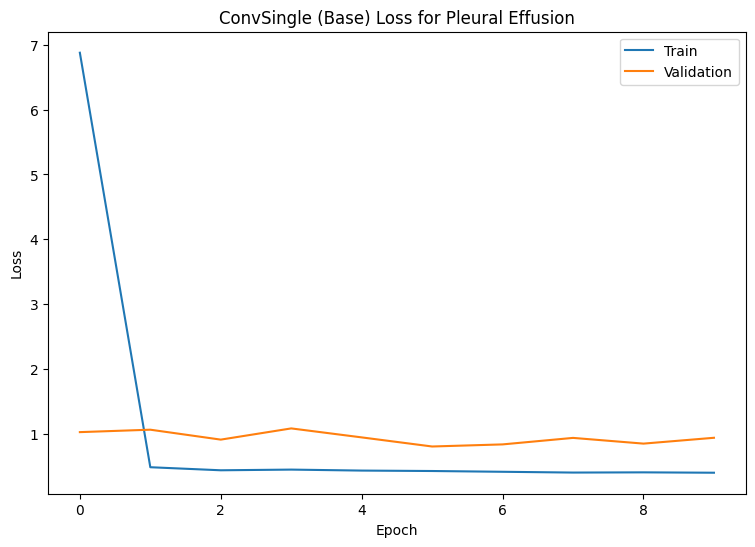

In [38]:
train_loss_pEff_copy = deepcopy(train_loss_pEff)
val_loss_pEff_copy = deepcopy(val_loss_pEff)
plot_values(train_loss_pEff_copy, val_loss_pEff_copy, "Loss", "ConvSingle (Base) Loss for Pleural Effusion")

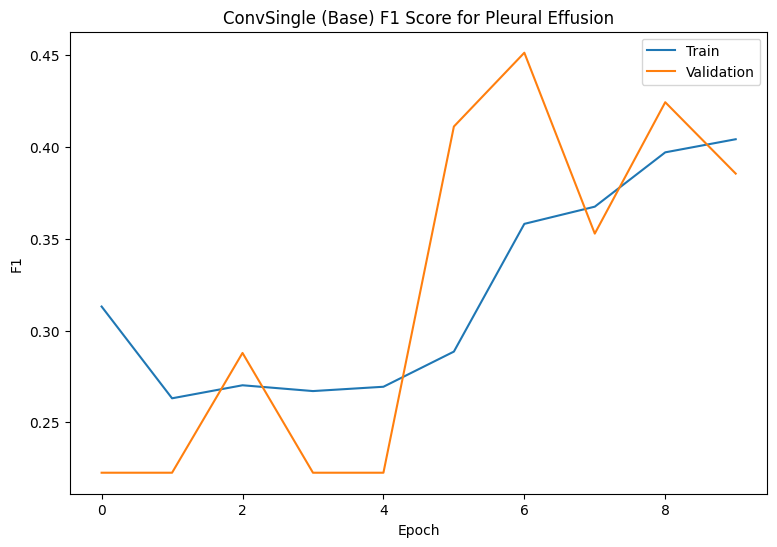

In [37]:
train_f1_pEff_copy = process_tensors(train_f1_pEff)
val_f1_pEff_copy = process_tensors(val_f1_pEff)

plot_values(train_f1_pEff_copy, val_f1_pEff_copy, "F1", "ConvSingle (Base) F1 Score for Pleural Effusion")

### Create Cardiomegaly Model

In [33]:
# Create Model
channels = (3, 8, 16, 32, 128)
input_size = (256, 256)
hidden_size = (8192, 512) 
output_size = 3
dropout_rate = 0.2

hyperparams_dict = {}
hyperparams_dict["channels"] = channels
hyperparams_dict["img_size"] = img_size
hyperparams_dict["hidden_size"] = hidden_size
hyperparams_dict["output_size"] = output_size
hyperparams_dict["dropout_rate"] = dropout_rate

name = "conv-single/randomSampler_cardio"

save_json(hyperparams_dict, f"../models/{name}")

model_cardio = ConvSingle(channels, input_size, hidden_size, output_size, dropout_rate).to(device)
print(model_cardio)

ConvSingle(
  (conv_layers): Sequential(
    (0): ConvolutionBlock(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvolutionBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvolutionBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

### Train Cardiomegaly Model

In [34]:
cardio_weights = [1149/6812, 1623/6812, 4040/6812]
train_loss_cardio, train_f1_cardio, val_loss_cardio, val_f1_cardio = train(model_cardio, cardio_weights, name, cardio_train_sampler_loader, cardio_valid_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 1/10: ---
Train loss: 15.6568, Train f1: 0.3212
Validation loss: 0.8710, Validation f1: 0.2252


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 2/10: ---
Train loss: 0.6937, Train f1: 0.2604
Validation loss: 1.0198, Validation f1: 0.2252


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 3/10: ---
Train loss: 0.6554, Train f1: 0.2490
Validation loss: 0.9918, Validation f1: 0.2252


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 4/10: ---
Train loss: 0.6289, Train f1: 0.2766
Validation loss: 0.9542, Validation f1: 0.2252


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 5/10: ---
Train loss: 0.5733, Train f1: 0.2616
Validation loss: 0.9811, Validation f1: 0.2252


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 6/10: ---
Train loss: 0.5977, Train f1: 0.2536
Validation loss: 0.9965, Validation f1: 0.2252


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 7/10: ---
Train loss: 0.5676, Train f1: 0.2684
Validation loss: 0.9881, Validation f1: 0.2252


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 8/10: ---
Train loss: 0.5408, Train f1: 0.2652
Validation loss: 0.9127, Validation f1: 0.2274


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 9/10: ---
Train loss: 0.5776, Train f1: 0.2880
Validation loss: 1.0291, Validation f1: 0.2279


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch 10/10: ---
Train loss: 0.5668, Train f1: 0.3096
Validation loss: 0.9148, Validation f1: 0.3068


### Plotters

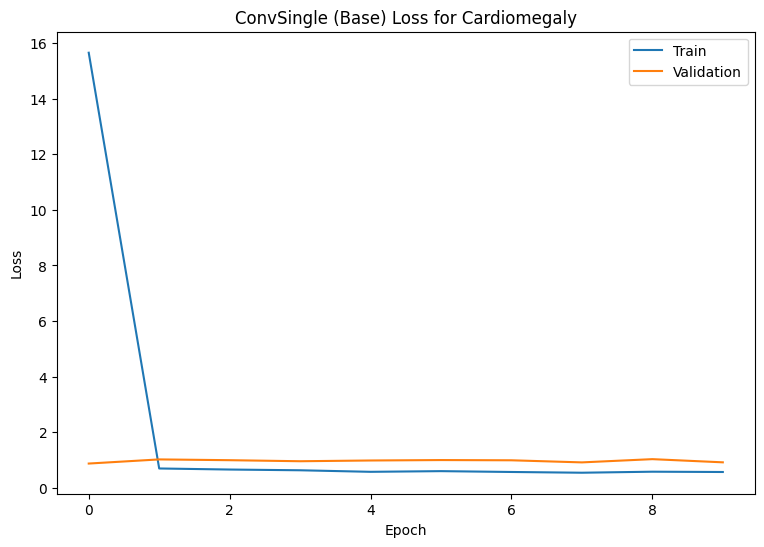

In [39]:
train_loss_cardio_copy = deepcopy(train_loss_cardio)
val_loss_cardio_copy = deepcopy(val_loss_cardio)
plot_values(train_loss_cardio_copy, val_loss_cardio_copy, "Loss", "ConvSingle (Base) Loss for Cardiomegaly")

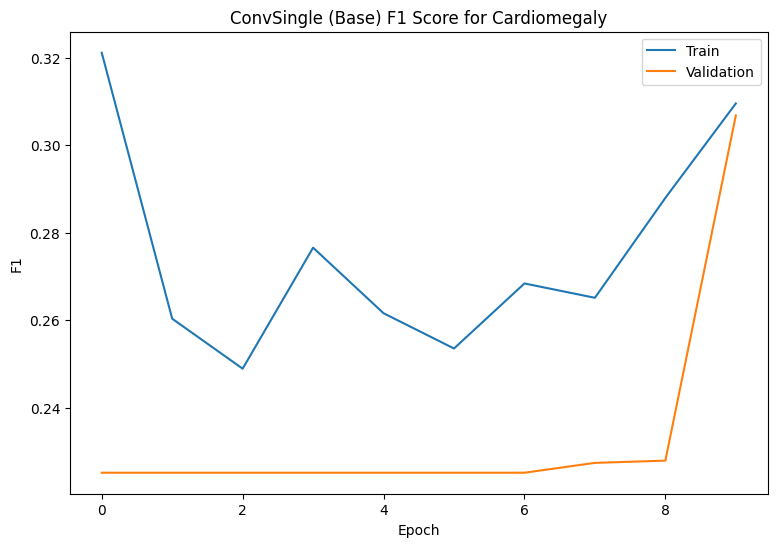

In [40]:
train_f1_cardio_copy = process_tensors(train_f1_cardio)
val_f1_cardio_copy = process_tensors(val_f1_cardio)

plot_values(train_f1_cardio_copy, val_f1_cardio_copy, "F1", "ConvSingle (Base) F1 Score for Cardiomegaly")